# Clustering

In [1]:
using Pkg
Pkg.activate("../env/.")
Pkg.instantiate()

  Activating project at `~/analogous_neural/env`


In [2]:
include("../src/analogous_bars.jl")
include("../src/Eirene_var.jl")

using .analogous_bars
using .Eirene_var

using DelimitedFiles
using Plots
using CSV
using Distances
using HDF5
using FileIO
using JLD


WebIO._IJuliaInit()

# 1. Load data 

In [4]:
# load points
data = load("data/clustering/points.jld")
P = collect(transpose(data["points"]))
Q = collect(transpose(data["centroids"]))
D = data["D"];

# prepare distances 
n_points = size(P)[1]
n_centroids = size(Q)[1]

# Define submatrices 
D_P = D[1:n_points, 1:n_points]
D_Q = D[n_points+1:end, n_points+1:end]
D_P_Q = D[1:n_points, n_points+1:end]
    # rows (landmarks): P
    # columns (witness) : Q
D_Q_P = D[n_points+1:end, 1:n_points];
    # rows (landmarks): Q
    # columns (witness) : P

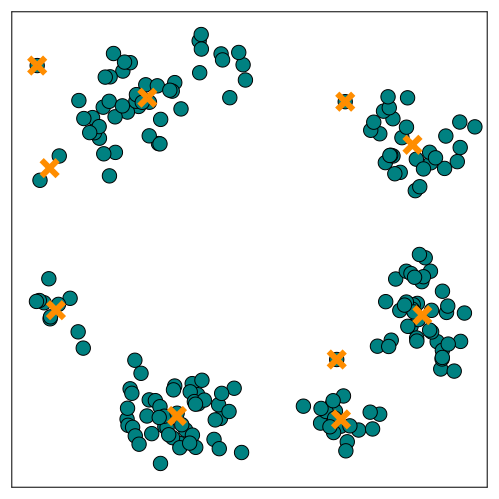

In [5]:
# plot points

p = plot(framestyle = :box, yaxis = nothing, xaxis = nothing,
        size = (500, 500), xlims = (-2.5, 2.3), ylims = (-2.5, 2.5))

scatter!(p,P[:,1], P[:,2], 
            color = "#008181", 
            label = "", 
            markersize = 8, 
            marker = :circle)

# plot Q
scatter!(p, Q[:,1], Q[:,2], 
            color = "#ff8d00", 
            label = "", 
            markersize = 8, 
            marker = :xcross,
            markerstrokewidth = 6
            )
#savefig("data/clustering/points.pdf")
plot(p)

In [6]:
# Compute Vietoris-Rips persistence on two regions
dim = 1
VR_P = eirene(D_P, record = "all", maxdim = dim)
VR_Q = eirene(D_Q, record = "all", maxdim = dim)

# compute Witness persistence
W_P = compute_Witness_persistence(D_P_Q, maxdim = dim)

Dict{Any, Any} with 8 entries:
  "fv"                         => Any[Any[0.106114, 0.165212, 0.352074, 0.32355…
  "param_max"                  => 4.20733
  "default_vertex_to_W_vertex" => nothing
  "simplex2index"              => Dict([52, 68, 78]=>775236, [116, 118, 155]=>1…
  "eirene_output"              => Dict{String, Any}("rv"=>Any[Int64[], [1, 2, 1…
  "index2simplex"              => Dict((578264, 2)=>[35, 196, 200], (682903, 2)…
  "distance_matrix"            => [0.106114 1.75141 … 4.13572 2.36115; 0.165212…
  "W_vertex_to_default_vertex" => nothing

In [7]:
# plot all PD
barcode_VR_P = barcode(VR_P, dim = 1)
barcode_W_P = barcode(W_P["eirene_output"], dim = 1)
barcode_VR_Q = barcode(VR_Q, dim = 1);

In [8]:
# select significant
selected_P, cutoff_P = select_persistent_intervals_IQR(barcode_VR_P)

([24], 0.14409629877935173)

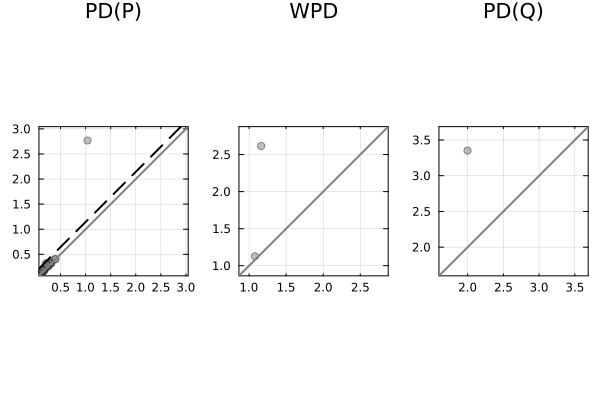

In [11]:
# plot all PD
p1 = plot_PD(barcode_VR_P, cutoff = cutoff_P, title = "PD(P)")
p2 = plot_PD(barcode_W_P, title = "WPD")
p3 = plot_PD(barcode_VR_Q, title = "PD(Q)")
plot(p1, p2, p3, layout = grid(1,3), size = (800, 300))

# Run Analogous cycles

In [10]:
analogous_P, analogous_Q = run_baseline_similarity_analogous(;
                                                                VR_P = VR_P,
                                                                D_P = D_P, 
                                                                VR_Q = VR_Q,
                                                                D_Q = D_Q, 
                                                                W_PQ = W_P, 
                                                                W_PQ_bars = [i for i=1:size(barcode_W_P,1)]);


# Organize output 
analogous_P_significant, analogous_Q_significant = analogous_cycles_significant(analogous_P, analogous_Q, significant_P = selected_P)

# print results
for k in keys(analogous_P_significant)
    println("*** Printing analogous pair *** ")
    println("In P: ", analogous_P_significant[k])
    println("In Q: ", analogous_Q_significant[k])
end 

*** Printing analogous pair *** 
In P: [24]
In Q: [1]
*** Printing analogous pair *** 
In P: nothing
In Q: nothing


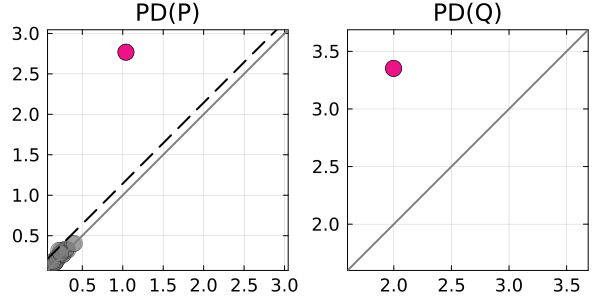

In [11]:
# plot all persistence diagrams & significance feature cutoff
p1 = plot_PD(barcode_VR_P; 
            highlight = [24],
            title = "PD(P)", 
            cutoff = cutoff_P,
            titlefontsize = 16,
            tickfontsize = 12,
            markersize = 9)

p2 = plot_PD(barcode_VR_Q; 
            highlight = [1],
            title = "PD(Q)", 
            markersize = 9,
            tickfontsize = 12,
            titlefontsize = 16)

plot(p1, p2, layout = grid(1,2), size = (600, 300))
#savefig("data/clustering/analogous_cycles.pdf")

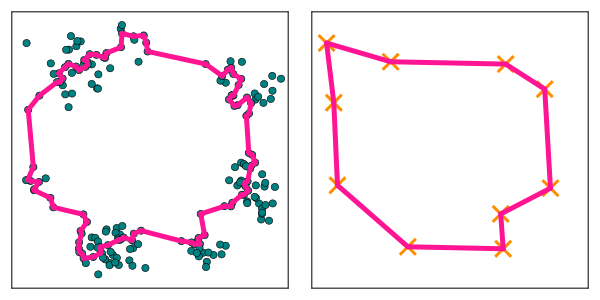

In [12]:
cr_P = get_cyclerep_Eirene(VR_P, 24)
cr_Q = get_cyclerep_Eirene(VR_Q, 1)

p1 = plot_cycle_single(transpose(P), cycle = cr_P, cycle_color = :deeppink, 
                markercolor = "#008181", title = ""; legend = false,
                xlims = (-2.5, 2.3), ylims = (-2.5, 2.5))
p2 = plot_cycle_single(transpose(Q), cycle = cr_Q, 
                cycle_color = :deeppink,
                xlims = (-2.5, 2.3), ylims = (-2.5, 2.5),
                color = "#ff8d00", 
                markersize = 8, 
                marker = :xcross,
                markerstrokewidth = 5,
                title = ""; legend = false)
plot(p1, p2, layout = grid(1,2), size = (600, 300))
#savefig("data/clustering/analogous_cycle_rep.pdf")